# Cluster Heatmaps

In [6]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot
from larval_gonad.config import memory
from larval_gonad.scRNAseq import CLUSTER_ANNOT, CLUSTER_ORDER

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='2018-05-04', subproject_dir='../output/paper_submission', 
                             seurat_dir='../output/combined_testis_force',
                             formats=['pdf', ],
                             styles=['notebook', 'paper']
                            )

last updated: 2018-05-04 
Git hash: 59ecd424780ee0f4946fac686cdb2769e214a832


In [7]:
clusters = nbconfig.seurat.get_clusters()
norm = nbconfig.seurat.get_normalized_read_counts()
tsne = nbconfig.seurat.get_tsne()

In [8]:
clusters = clusters['res.0.4']
clusters.name = 'cluster'

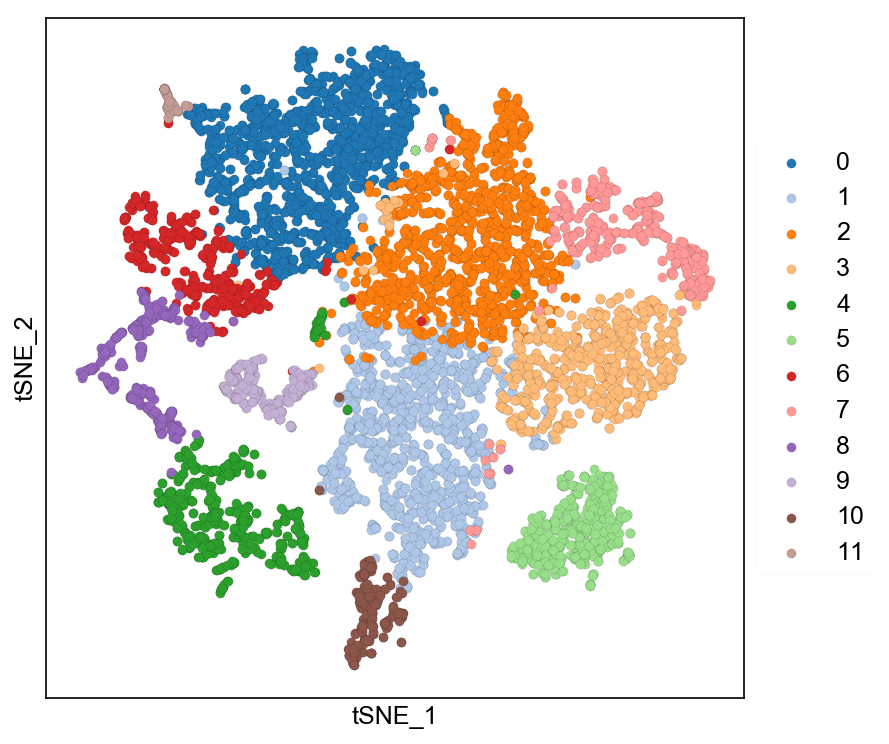

In [9]:
TSNEPlot(data=tsne.join(clusters), hue='cluster', palette=sns.color_palette('tab20', n_colors=12))

In [11]:
dat = norm.T.join(clusters.apply(lambda x: CLUSTER_ANNOT[x])).groupby('cluster').sum().T[CLUSTER_ORDER]

In [12]:
bio = pd.read_csv(Path(nbconfig.seurat_dir, 'biomarkers_0.4.tsv'), sep='\t')
sig_genes = bio[bio.p_val_adj < 0.001].primary_FBgn.unique().tolist()

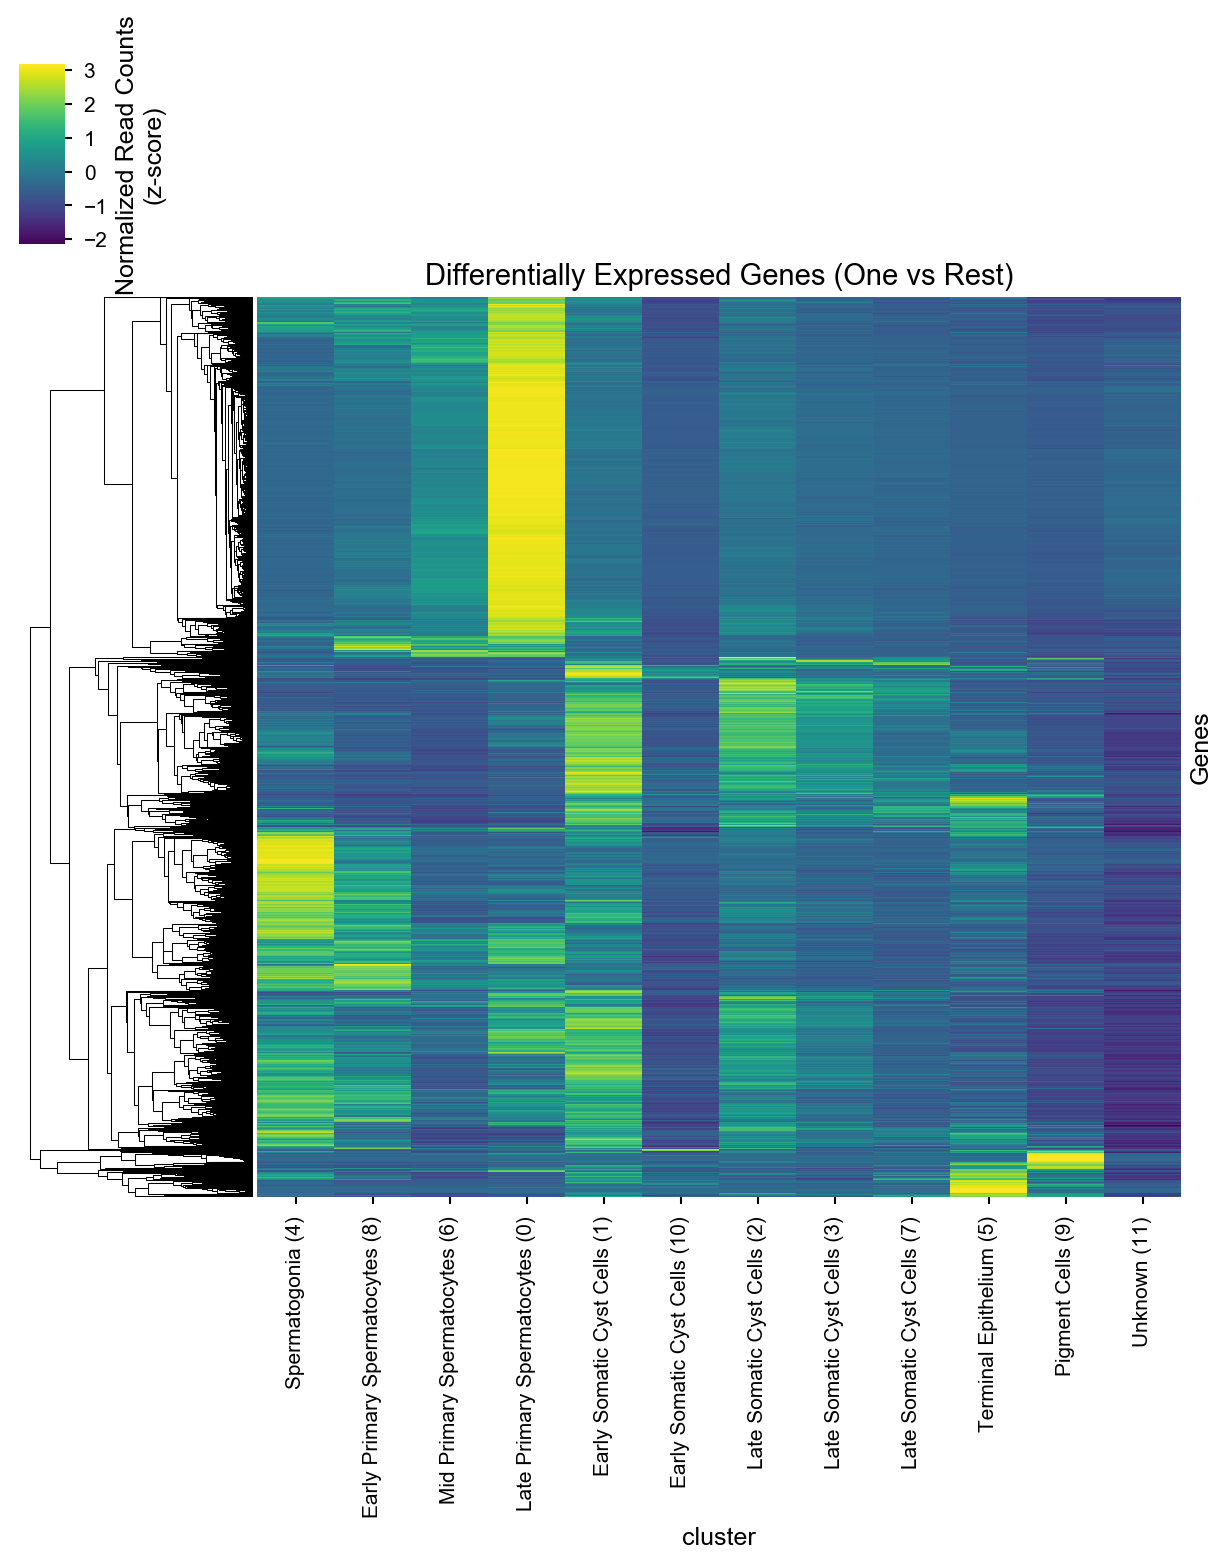

In [13]:
@make_figs(nbconfig.fig_name('heatmap_diff_genes'), styles=['notebook', 'paper'], formats='pdf', layout=False)
def _plot():
    g = sns.clustermap(dat[dat.index.isin(sig_genes)],
                       col_cluster=False, 
                       yticklabels=False, 
                       z_score=0,
                       cmap='viridis',
                       cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                       rasterized=True,
                      )
    g.ax_heatmap.set_title('Differentially Expressed Genes (One vs Rest)')
    g.ax_heatmap.set_ylabel('Genes')
    
_plot()

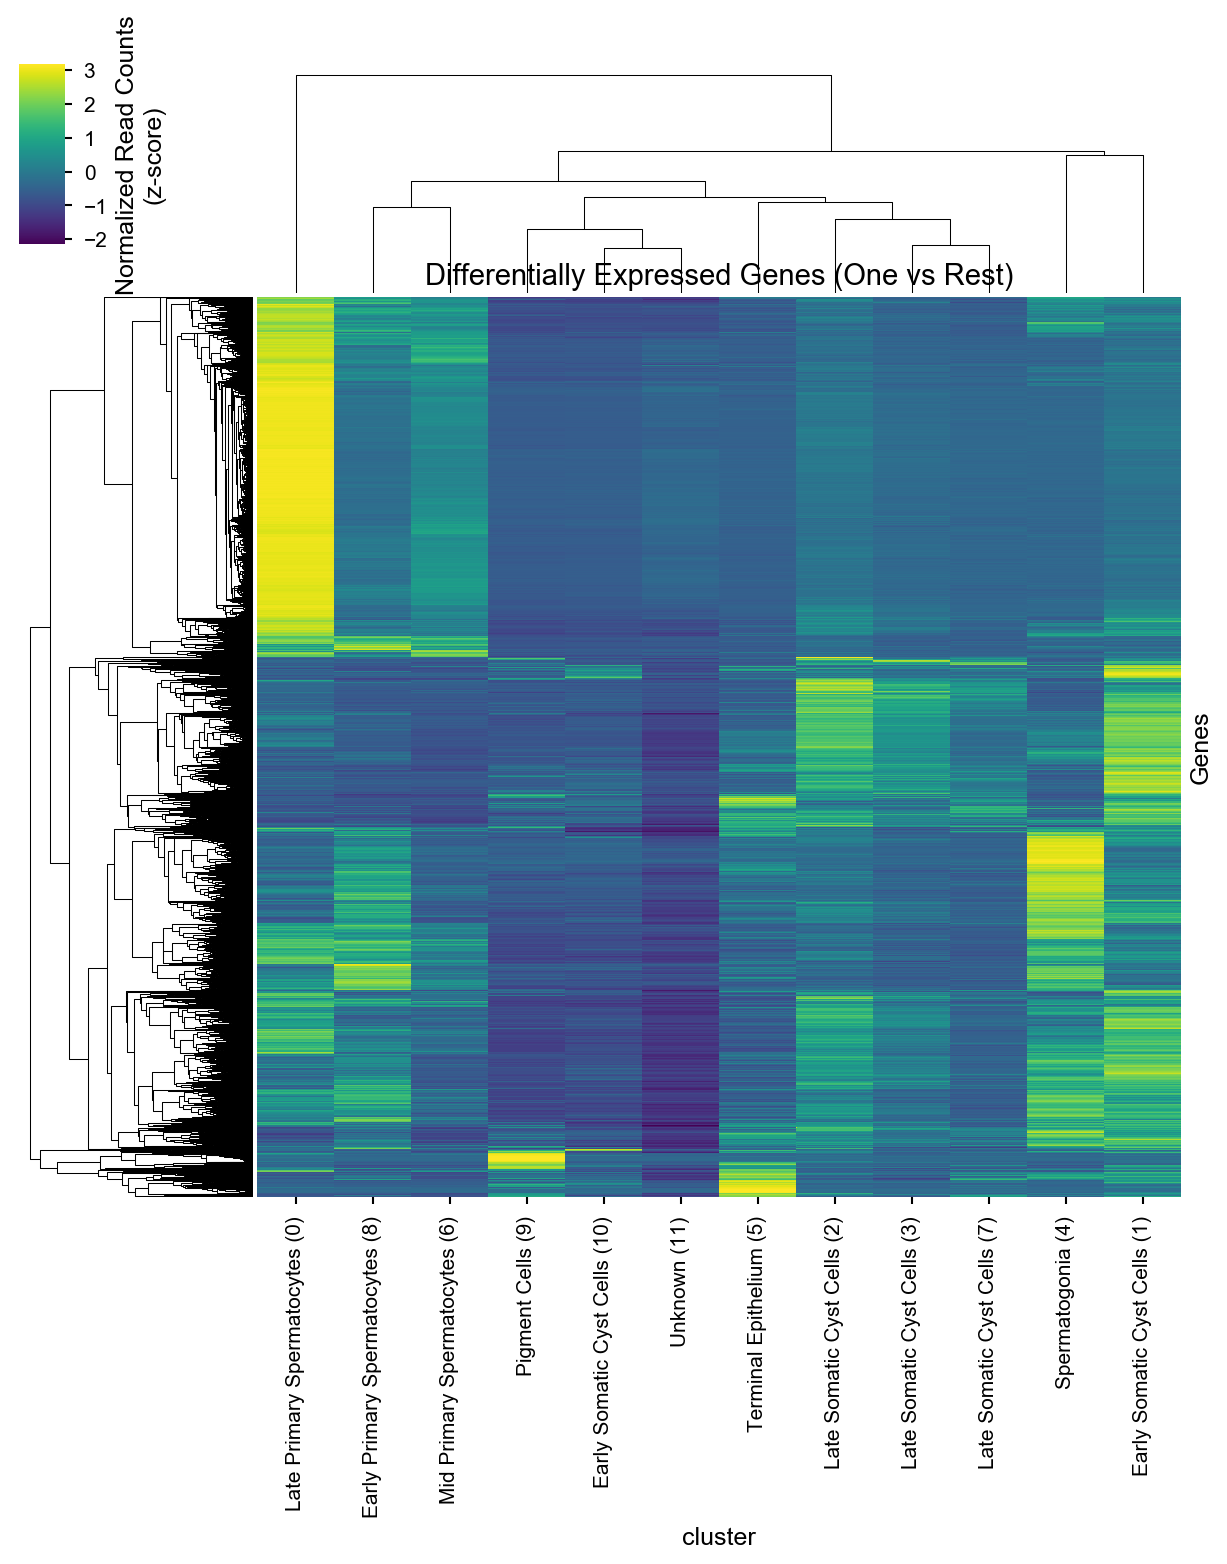

In [23]:
@make_figs(nbconfig.fig_name('heatmap_diff_genes_col_clus'), styles=['notebook', 'paper'], formats='pdf', layout=False)
def _plot():
    g = sns.clustermap(dat[dat.index.isin(sig_genes)],
                       col_cluster=True, 
                       yticklabels=False, 
                       z_score=0,
                       cmap='viridis',
                       cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                       rasterized=True,
                      )
    g.ax_heatmap.set_title('Differentially Expressed Genes (One vs Rest)')
    g.ax_heatmap.set_ylabel('Genes')
    
_plot()

In [24]:
cgs = []
for k, v in nbconfig.fbgn2symbol.items():
    if v.startswith('CG') | v.startswith('CR'):
        cgs.append(k)

In [25]:
top_10 = bio[~bio.primary_FBgn.isin(cgs)].sort_values(['cluster', 'p_val_adj', 'avg_logFC']).groupby('cluster').head(10).primary_FBgn.unique().tolist()

Text(0.5,1,'Top 10 Differentially Expressed Genes (One vs Rest)')

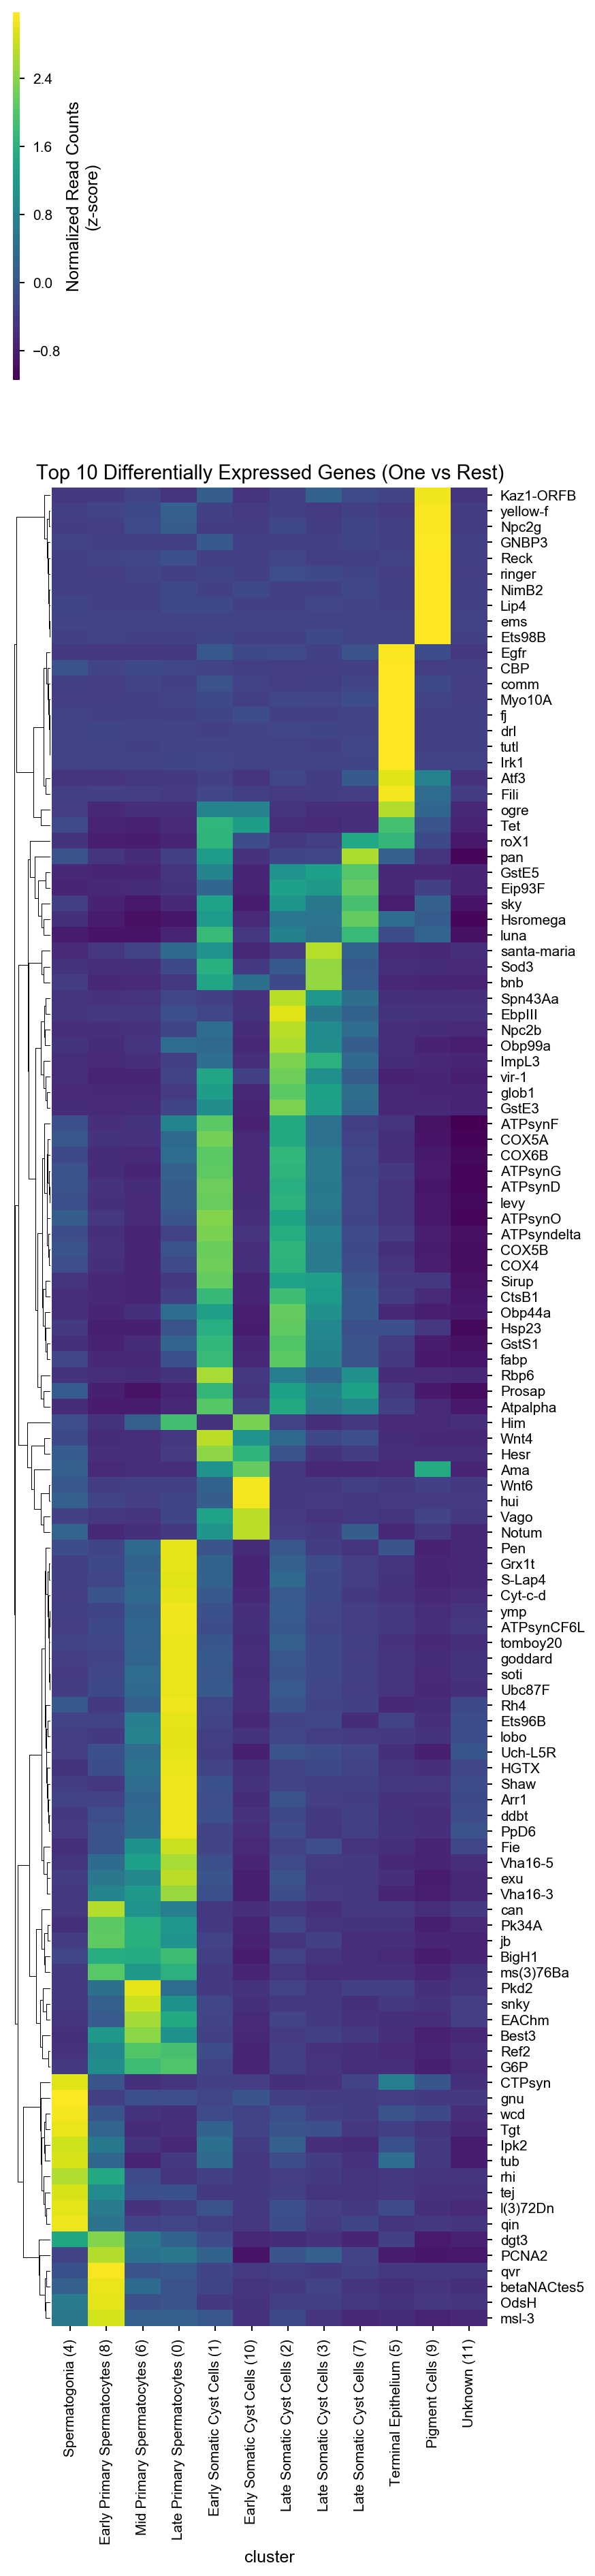

In [26]:
g = sns.clustermap(dat[dat.index.isin(top_10)],  
                   col_cluster=False,  
                   z_score=0, 
                   figsize=(6, 30), 
                   cmap='viridis',
                   cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                   rasterized=True,
                  )

ax = g.ax_heatmap
new_labels = []
for l in ax.get_yticklabels():
    new_labels.append(nbconfig.fbgn2symbol[l.get_text()])
    
ax.set_yticklabels(new_labels);
ax.set_title('Top 10 Differentially Expressed Genes (One vs Rest)')

In [27]:
# literature

In [28]:
spermatogonia = [
    'vas',
    'bam',
    'p53'
]

early_primary_sperm = [
    'nht', 
    'can',
    'aly', 
]

late_primary_spermatocyte = [
    'fzo', 
    'soti', 
    'bol',
    'dj',
    'ocn',
]

early_soma = [
    'tj',
    'hui', 
    'sano', 
]

late_soma = [
    'eya', 
    'glob1', 
    'Eip93F', 
]


terminal = [
    'nord',
    'retn',
    'Abd-B',
]

pigment = [
    'vkg', 
    'Sox100B', 
    'bw',
]




In [29]:
select = []
for gene in spermatogonia + early_primary_sperm + late_primary_spermatocyte + early_soma + late_soma + terminal + pigment: 
    fbgn = nbconfig.symbol2fbgn[gene]
    if fbgn in dat.index:
        select.append(fbgn)

In [30]:
len(select)

23

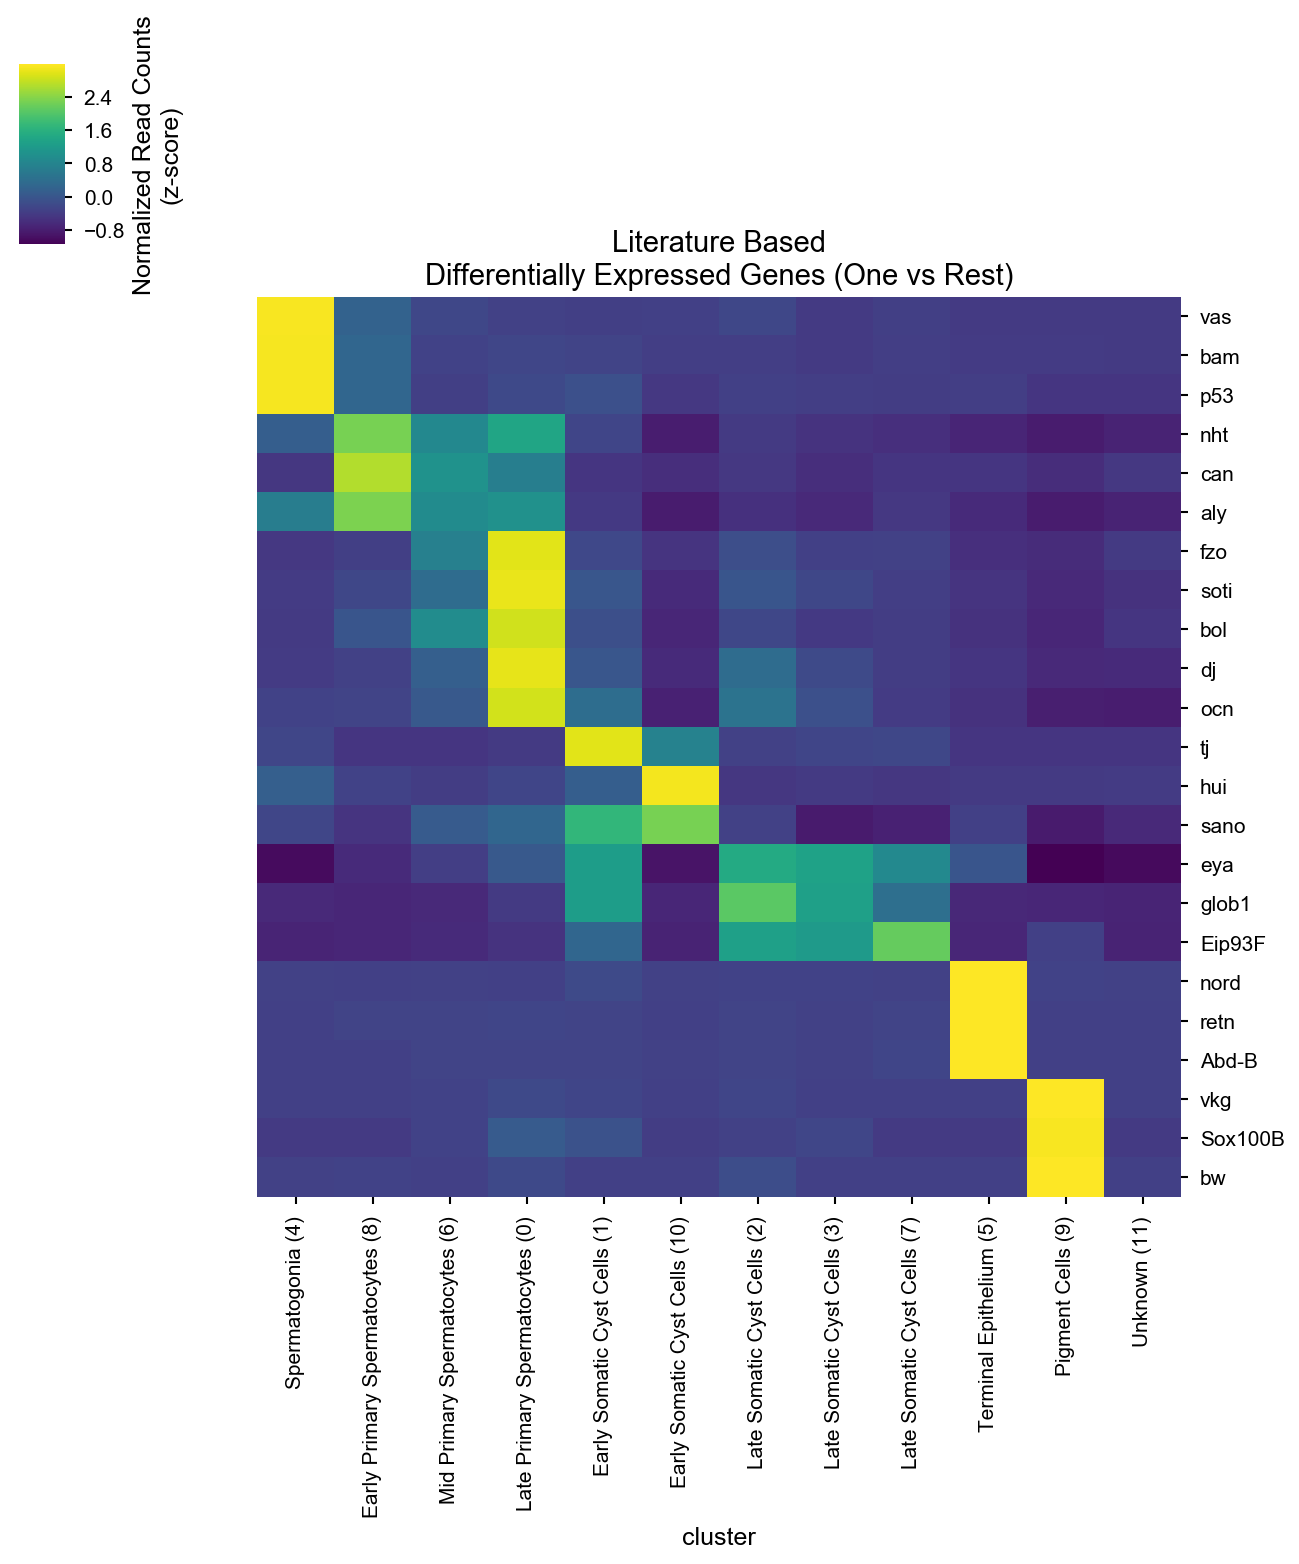

In [31]:
@make_figs(fname=nbconfig.fig_name('heatmap_literature_genes'), styles=nbconfig.styles,
           formats=nbconfig.formats,
           layout=False
          )
def _plot():
    g = sns.clustermap(dat.loc[select],  
                       col_cluster=False,  
                       row_cluster=False,  
                       z_score=0, 
                       cmap='viridis',
                       cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                       rasterized=True,
                      )

    ax = g.ax_heatmap
    new_labels = []
    for l in ax.get_yticklabels():
        new_labels.append(nbconfig.fbgn2symbol[l.get_text()])

    ax.set_yticklabels(new_labels);
    ax.set_title('Literature Based\nDifferentially Expressed Genes (One vs Rest)')
    
_plot()